In [2]:
import numpy as np
import scipy
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import collections  as mc
%matplotlib inline

import glob
import os
import pickle
import datetime


if "__file__" not in dir():
    %run loadRat_documentation.ipynb
    %run loadRawSpike_documentation.ipynb


    
# INFO: all the default parameters for preprocessing
defaultParam={
    "binSize":0.25,
    "trialOffset":20., #max end of trial, in seconds (position will be cutted)
    "sigmaSmoothPosition":0.1,  #smooth the position
    #"sigmaSmoothPosition":0.33 for pavel dataType
    "sigmaSmoothSpeed":0.3, #smooth the speed
    "positionDiffRange": [2.,5.], #min and max differences allowed between two consecutive positions
                                  #min to correct start, max to correct jumps
    "pawFrequencyRange":[2.,10.],
    "startAnalysisParams":[10,0.2,0.5],
    "cameraToTreadmillDelay":2., #seconds, usual time between camera start and treadmill start
    "nbJumpMax" : 100., #if jumps>nbJumpMax, trial is badly tracked
    
    #parameter to detect end of trial (first position minima)
    "endTrial_backPos":55,  # minima is after the animal went once to the back (after first time position>backPos)
    "endTrial_frontPos":30, # minima's position is in front of treadmill (position[end]<frontPos)
    "endTrial_minTimeSec":4, # minima is after minTimeSec seconds (time[end]>minTimeSec)
    }

### Load Data
Load the preprocess data (corrected and binned position, speed, median position, ...)
 DEFAULT: load pickle if they exist, or create them
data=Data(root,animal,experiment,param=param)

 OPTION 1: do not save any new pickle file
data=Data(root,animal,experiment,param,saveAsPickle=False)

 OPTION 2: redo the preprocessing with param, even if the pickle already exist
 (to be sure everything is preprocess with the same parameters)

In [3]:
if "__file__" not in dir():
    root="/data"
    animal="Rat034"
    experiment="Rat034_2015_02_20_13_34"
    param={
        "goalTime":7,
        "treadmillRange":[0,90],
        "maxTrialDuration":20,
        "interTrialDuration":10,
        "endTrial_frontPos":30,
        "endTrial_backPos":55, 
        "endTrial_minTimeSec":4,
        "binSize":0.25,
    }  
    data=Data(root,animal,experiment,param,redoPreprocess=True)

Preprocessing behavior data...
No *.lickbreaktime file found!
Behavior data loaded from text files: Teresa data (.samplingrate)
Preprocessing done
09:58:44 [W] Could not find any data source for traces (raw.kwd or .dat or .bin.) Waveforms and traces will not be available.
Features and masks initialized.
Initializing statistics: 100.0%.
Statistics initialized.
Initializing statistics: 100.0%.
09:58:44 [I] Switched to channel group 2.
Features and masks initialized.
Initializing statistics: 100.0%.
Statistics initialized.
Initializing statistics: 100.0%.
09:58:44 [I] Switched to channel group 3.
Features and masks initialized.
Initializing statistics: 100.0%.
Statistics initialized.
Initializing statistics: 100.0%.
09:58:45 [I] Switched to channel group 4.
Features and masks initialized.
Initializing statistics: 100.0%.
Statistics initialized.
Initializing statistics: 100.0%.
Spike data loaded from raw files


### Display all attributes and their type  
Every attributes can be access with `data.attributeName`  

In [4]:
#run only if inside this notebook (do not execute if "%run this_notebook")
if "__file__" not in dir():
    data.describe()
    print(data.emptyAnalysisFiles)

Session: Rat034_2015_02_20_13_34
Full Path: /data/Rat034/Experiments/Rat034_2015_02_20_13_34/Rat034_2015_02_20_13_34
Number of trials: 159
---------------------------------------------------------------------------------------------
**Name**                     **Type**   **Content**                    **Extract**                   
---------------------------------------------------------------------------------------------
accelerationOnSpeedBin       dict       nKeys=159                      keys: [0, 1, 2, 3, 4, 5, 6,...
accelerationOnSpeedSmoothBin dict       nKeys=159                      keys: [0, 1, 2, 3, 4, 5, 6,...
amplification                int        1000                                                         
analysisPath                 str        /data/Rat034/Experiments/Rat034_2015_02_20_13_34/Analysis                               
animal                       str        Rat034                                                       
binSize                      float

### Shank and their clusters, per group

In [6]:
#run only if inside this notebook (do not execute if "%run this_notebook")
if "__file__" not in dir():
    # add a list of (shank,clu) in a group "testGroup"
    #data.add_cluster_group("testGroup",[(1,2),(1,3),(2,4)])
    if not data.hasSpike:
        print("no spike data")
    else:
        #display all groups for every shank
        for shank in data.channelGroupList:
            print("shank %s:"%shank)
            print(data.clusterGroup[shank])
        print(data.channelGroupList)

shank 1:
{'Unsorted': [3, 8, 9, 10, 11, 16, 17, 21, 29, 30, 32, 33], 'Good': [2, 6, 7, 12, 13, 18, 23, 43, 44], 'MUA': [5, 14, 40], 'Noise': [1, 4, 19, 20, 22, 24, 25, 26, 27, 28, 34, 35, 36, 37, 38, 39, 41, 42]}
shank 2:
{'Unsorted': [6, 7, 9, 18, 19, 24, 25, 31, 32, 38, 41, 42, 46, 47, 48, 49, 54, 62, 63], 'Good': [8, 14, 20, 74, 77, 83, 84], 'MUA': [10, 36, 37, 43, 58, 59, 67, 68, 70], 'Noise': [1, 2, 11, 13, 22, 23, 50, 51, 52, 56, 57, 61, 64, 65, 66, 69, 71]}
shank 3:
{'Unsorted': [3, 4, 9, 14, 17, 19, 31, 32], 'Good': [6, 7, 8, 11, 12, 13, 15, 16, 29, 36, 37, 50, 57, 59, 60, 61], 'MUA': [23, 26, 46, 48], 'Noise': [1, 10, 20, 21, 24, 25, 33, 34, 35, 39, 40, 41, 44, 45, 47, 49, 51, 52, 53, 54, 55, 56]}
shank 4:
{'Unsorted': [6, 8, 11, 16, 22, 25, 26, 28, 33, 34, 36, 39, 40, 41, 43, 51, 53, 59, 69, 70], 'Good': [7, 21, 31, 32, 38, 42, 47, 55, 63, 65, 68, 84, 87, 89, 90, 92], 'MUA': [2, 5, 9, 14, 48, 54, 58, 60, 61, 67, 72, 73, 78, 79], 'Noise': [1, 4, 10, 13, 18, 20, 24, 35, 44, 45,

# Spiking Activity : Needs Revision

### Spike Raster

{1: {'Unsorted': [3, 8, 9, 10, 11, 16, 17, 21, 29, 30, 32, 33], 'Good': [2, 6, 7, 12, 13, 18, 23, 43, 44], 'MUA': [5, 14, 40], 'Noise': [1, 4, 19, 20, 22, 24, 25, 26, 27, 28, 34, 35, 36, 37, 38, 39, 41, 42]}, 2: {'Unsorted': [6, 7, 9, 18, 19, 24, 25, 31, 32, 38, 41, 42, 46, 47, 48, 49, 54, 62, 63], 'Good': [8, 14, 20, 74, 77, 83, 84], 'MUA': [10, 36, 37, 43, 58, 59, 67, 68, 70], 'Noise': [1, 2, 11, 13, 22, 23, 50, 51, 52, 56, 57, 61, 64, 65, 66, 69, 71]}, 3: {'Unsorted': [3, 4, 9, 14, 17, 19, 31, 32], 'Good': [6, 7, 8, 11, 12, 13, 15, 16, 29, 36, 37, 50, 57, 59, 60, 61], 'MUA': [23, 26, 46, 48], 'Noise': [1, 10, 20, 21, 24, 25, 33, 34, 35, 39, 40, 41, 44, 45, 47, 49, 51, 52, 53, 54, 55, 56]}, 4: {'Unsorted': [6, 8, 11, 16, 22, 25, 26, 28, 33, 34, 36, 39, 40, 41, 43, 51, 53, 59, 69, 70], 'Good': [7, 21, 31, 32, 38, 42, 47, 55, 63, 65, 68, 84, 87, 89, 90, 92], 'MUA': [2, 5, 9, 14, 48, 54, 58, 60, 61, 67, 72, 73, 78, 79], 'Noise': [1, 4, 10, 13, 18, 20, 24, 35, 44, 45, 49, 50, 52, 56, 57,

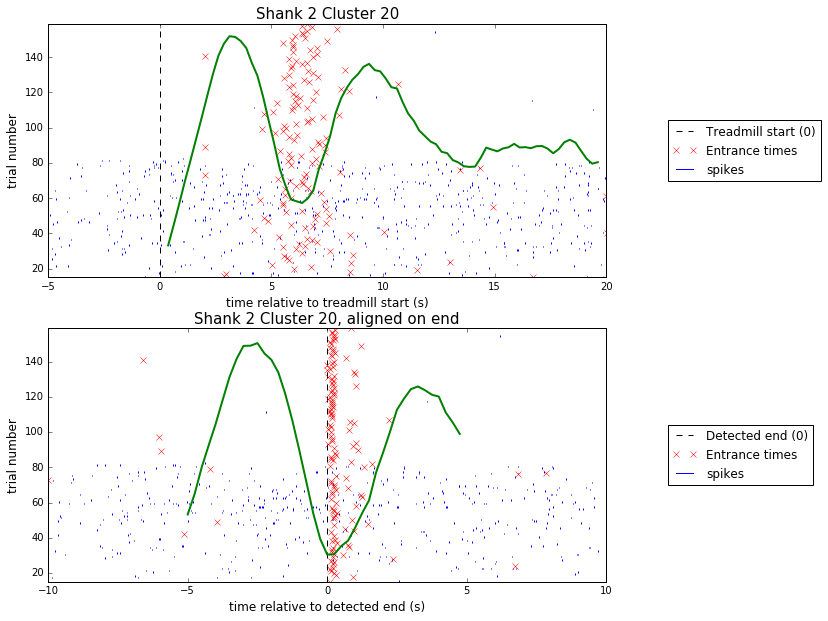

In [28]:
def plot_raster(data,shank,cluster,minTime=-5,maxTime=20,firstTrial=15,ax=None,legend=False,alignEnd=False):
    if ax is None:
        ax=plt.gca()
        
    ax.set_ylim(firstTrial,data.nTrial)
    ax.set_ylabel('trial number',fontsize=12)

    if alignEnd:
        ax.axvline(x=0,linestyle="--",color="k",label="Detected end (0)")
        ax.set_xlabel('time relative to detected end (s)',fontsize=12)
        ax.set_title('Shank %s Cluster %s, aligned on end'%(shank,cluster),fontsize=15)
    else:
        ax.axvline(x=0,linestyle="--",color="k",label="Treadmill start (0)")
        ax.set_xlabel('time relative to treadmill start (s)',fontsize=12)
        ax.set_title('Shank %s Cluster %s'%(shank,cluster),fontsize=15)

    cluSpikeTime=data.spikeTime[shank][cluster]
    lines=[]
    for trial in data.trials:
        zero=data.treadmillStartTime[trial]
        if alignEnd:
            end=data.timeEndTrial[trial]
            if isNone(end):
                continue
            zero=zero+end
        start=zero+minTime
        stop=zero+maxTime
        trialSpikeTime=cluSpikeTime[(cluSpikeTime>=start)&(cluSpikeTime<=stop)]
        for spikeTime in trialSpikeTime:
            alignTime=spikeTime-zero
            lines.append([(alignTime,trial+1),(alignTime,trial+1.9)])        
    lc= mc.LineCollection(lines,colors="blue",label="spikes")
    ax.add_collection(lc)
        
    ax.set_xlim([minTime,maxTime])
    
    ax2=ax.twinx()
    ax2.axis("off")
    
    #Plot median position and entrance time
    if alignEnd:
        trials=[trial for trial in data.trials if not isNone(data.timeEndTrial[trial])]
        entrance=[data.entranceTime[trial]-data.timeEndTrial[trial] for trial in trials]
        trialAxis=[trial+1 for trial in trials]
        ax2.plot(data.timeAlignEnd,data.medianPositionAlignEnd,'g-',linewidth=2,label="Median position")
        ax.plot(entrance,trialAxis,'rx',label="Entrance times");
    else:
        entrance=[data.entranceTime[trial] for trial in data.trials]
        trialAxis=np.arange(1,data.nTrial+1)+0.4
        ax2.plot(data.timeBin,data.medianPosition,'g-',linewidth=2,label="Median position");
        ax.plot(entrance,data.realTrials,'rx',label="Entrance times");
            
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5));
        
#----------------------------------------------------------------------------------------------------------------------
if "__file__" not in dir():
    print(data.clusterGroup)
    SHANK=2
    CLU=20
    plt.figure(figsize=(10,10))
    plt.subplot(211)
    plot_raster(data,SHANK,CLU,legend=True)
    plt.subplot(212)
    plot_raster(data,SHANK,CLU,legend=True,minTime=-10,maxTime=10,alignEnd=True)

### Raster and mean with firing rate

`pcolormesh(x,y,res)`: x and y are coordinates of rectangles. Each rectangle is colored according to the value in res

To display `res` as 3x3 cells, you need:

      res        x        y
               |0 1 2 3|  |0|
    |0 1 2|               |1|
    |4 0 0|               |2|
    |5 3 1|               |3|

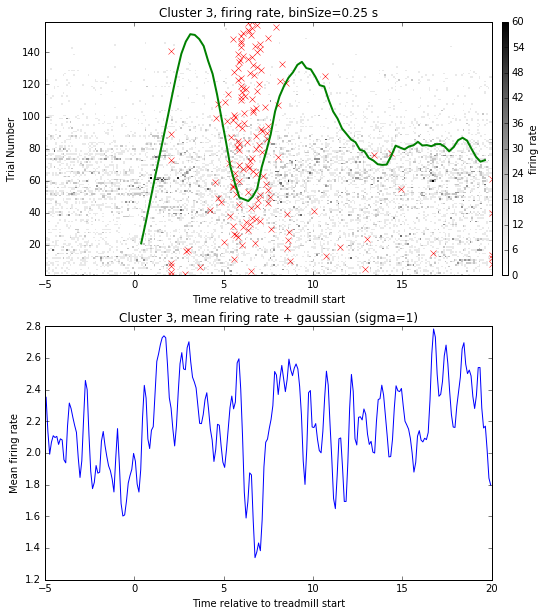

In [8]:
def compute_firing_rate(data,shank,cluster,binSize,minTime,maxTime):
    timeBin=np.arange(minTime,maxTime+binSize-maxTime%binSize,binSize)
    firingRate={}
    spikeTime=data.spikeTime[shank][cluster]
    for trial in data.trials:
        zero=data.treadmillStartTime[trial]
        start=zero+minTime
        stop=zero+maxTime
        trialSpikeTime=spikeTime[(spikeTime>=start)&(spikeTime<=stop)]
        alignedTime=trialSpikeTime-zero
        hist,bins=np.histogram(alignedTime,timeBin)
        firingRate[trial]=hist/float(binSize)
    center=(timeBin[:-1]+timeBin[1:])/2
    return firingRate,center,timeBin

#----------------------------------------------------------------------------------------------------------------------
def plot_raster_firing_rate(data,shank,cluster,binSize=0.25,minTime=-5,maxTime=20,ax=None):
    if ax is None:
        ax=plt.gca()
        
    firingRate,center,timeBin=compute_firing_rate(data,shank,cluster,binSize,minTime,maxTime)
    res=np.asarray(list(firingRate.values()))
    
    y= [t+0.5 for t in range(1,len(data.trials)+2)]
    resColor=ax.pcolormesh(timeBin,y,res,cmap="Greys")

    box = ax.get_position()
    axColor = plt.axes([box.x0*1.02 + box.width * 1.02, box.y0, 0.01, box.height])
    plt.colorbar(resColor, cax=axColor, label="firing rate")

    ax2=ax.twinx()
    ax2.plot(data.timeBin,data.medianPosition,'g-',linewidth=2,label="Median position");
    ax2.axis("off")
    
    entrance=[data.entranceTime[trial-1] for trial in data.realTrials]
    ax.plot(entrance,data.realTrials,"rx")
    
    ax.set_xlim([timeBin[0],timeBin[-1]])
    ax.set_ylim([data.realTrials[0],data.realTrials[-1]])
    ax.set_xlabel("Time relative to treadmill start")
    ax.set_ylabel("Trial Number")
    ax.set_title("Cluster %s, firing rate, binSize=%s s"%(cluster,data.binSize))

#----------------------------------------------------------------------------------------------------------------------
def plot_mean_firing_rate(data,shank,cluster,binSize=0.25,minTime=-5,maxTime=20,sigma=1,ax=None):
    if ax is None:
        ax=plt.gca()
    
    firingRate,center,timeBin=compute_firing_rate(data,shank,cluster,binSize,minTime,maxTime)
    spikeCount=np.mean(list(firingRate.values()),axis=0)
    
    import scipy.ndimage as scImage
    smoothSpikeCount=scImage.filters.gaussian_filter1d(spikeCount, sigma) 
    
    ax.plot(center,smoothSpikeCount);
    ax.set_xlabel("Time relative to treadmill start")
    ax.set_ylabel("Mean firing rate")
    ax.set_title("Cluster %s, mean firing rate + gaussian (sigma=%s)"%(cluster,sigma))  

#----------------------------------------------------------------------------------------------------------------------
if "__file__" not in dir():
    SHANK=1
    CLU=3

    plt.figure(figsize=(8,10))
    plt.subplot(211)
    plot_raster_firing_rate(data,SHANK,CLU,binSize=0.1)

    plt.subplot(212)
    plot_mean_firing_rate(data,SHANK,CLU,binSize=0.1,sigma=1)

### Raster trial by trial

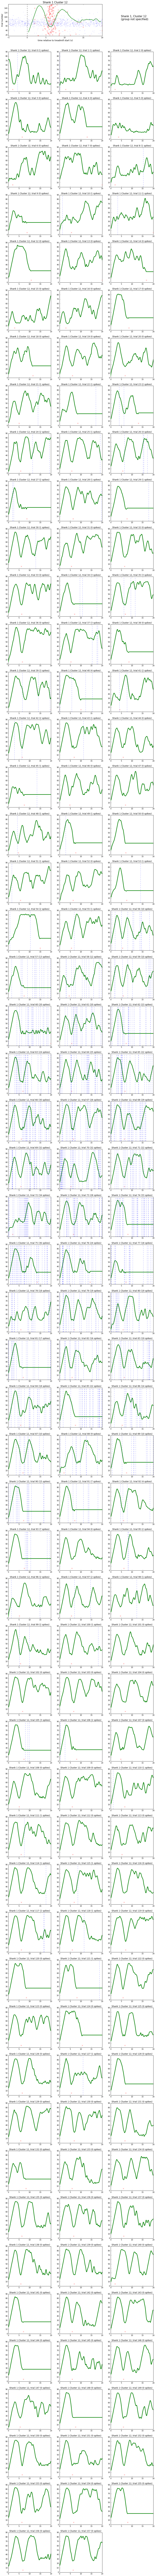

In [10]:
def plot_raster_one_trial(data,shank,cluster,trial,minTime=0,maxTime=20,ax=None):
    '''
    Position for one trial + spike times for one cluster
    Paw=True: plot paw position
    A trial time range is [treadmillStart+minTime, treadmillStart+maxTime]
    times are aligned on treadmillStart
    '''
    if ax is None:
        ax=plt.gca()
    if trial in data.trialNotTracked:
        print("Trial not tracked")
        return

    cluData=data.spikeTime[shank][cluster]

    zero=data.treadmillStartTime[trial]
    start=zero+minTime
    stop=zero+maxTime
    trialSpikeTime=cluData[(cluData>start)&(cluData<stop)]-zero
   
    ax2=ax.twinx()
    ax2.axis("off")
    lines=[]
    for spike in trialSpikeTime:
        lines.append([(spike,0),(spike,1)])
    lc= mc.LineCollection(lines,colors="blue",label="spike",linestyle="--",linewidth=0.5)
    ax2.add_collection(lc)
    nbSpike=len(trialSpikeTime)

    ax.plot(data.entranceTime[trial],5,'rx',zorder=10);
    ax.plot(data.timeTreadmill[trial],data.position[trial],'g-',linewidth=3,zorder=9);

    ax.set_ylim(data.treadmillRange)
    ax.set_xlim([minTime,maxTime])
    ax.set_title('Shank %s Cluster %s, trial %s (%s spikes)'%(shank,cluster,trial,nbSpike));

#----------------------------------------------------------------------------------------------------------------------
def plot_raster_trial_by_trial(data,shank,cluster,group="not specified",minTime=0,maxTime=20,paw=False):
    '''
    -Raster for all trials with median position (firing rate if nbSpike>20000)
    -One plot for every trial (plot_raster_one_trial: position + spike time)
    Paw=True: plot paw position
    A trial time range is [treadmillStart+minTime, treadmillStart+maxTime]
    times are aligned on treadmillStart
    '''
    nbcol=3 #nbcol=2 will result in Value Error (plot too big) 
    nbLines=int(np.ceil(data.nTrial*1.0/nbcol))
    gs=gridspec.GridSpec(nbLines+1,nbcol,hspace=0.5)

    plt.figure(figsize=(15,nbLines*(15.0/nbcol)))
    ax=plt.subplot(gs[0,0:2])
    if len(data.spikeTime[shank][cluster])<20000:
        plot_raster(data,shank,cluster)
    else:
        plot_raster_firing_rate(data,shank,cluster)
    ax.text(1.2,0.5,"Shank %s, Cluster %s \n(group %s)"%(shank,cluster,group),transform=ax.transAxes,fontsize=15)

    gs=gridspec.GridSpec(nbLines+1,nbcol,hspace=0.2)

    for trial in data.trials[:-1]:
        axT = plt.subplot(gs[1+trial//nbcol,trial%nbcol])
        plot_raster_one_trial(data,shank,cluster,trial,minTime,maxTime,ax=axT)
#----------------------------------------------------------------------------------------------------------------------
if "__file__" not in dir():
    SHANK=1
    CLU=12
    #print(data.trialNotTracked)
    #plot_raster_one_trial(data,SHANK,CLU,trial=4)

    plot_raster_trial_by_trial(data,SHANK,CLU)

In [11]:
#def plot_raster_trial_by_trial_new(data,shank,cluster,group="not specified",minTime=0,maxTime=20,paw=False):
def plot_raster_trial_by_trial_new(data,group="Good",minTime=0,maxTime=20,paw=False):
    '''
    -Raster for all trials with median position (firing rate if nbSpike>20000)
    -One plot for every trial (plot_raster_one_trial: position + spike time)
    Paw=True: plot paw position
    A trial time range is [treadmillStart+minTime, treadmillStart+maxTime]
    times are aligned on treadmillStart
    '''
    #nbcol=3 #nbcol=2 will result in Value Error (plot too big) 
    #nbLines=int(np.ceil(data.nTrial*1.0/nbcol))
    #gs=gridspec.GridSpec(nbLines+1,nbcol,hspace=0.5)

    #plt.figure(figsize=(15,nbLines*(15.0/nbcol)))
    #ax=plt.subplot(gs[0,0:2])
    #if len(data.spikeTime[shank][cluster])<20000:
        #plot_raster(data,shank,cluster)
    #else:
        #plot_raster_firing_rate(data,shank,cluster)
    #ax.text(1.2,0.5,"Shank %s, Cluster %s \n(group %s)"%(shank,cluster,group),transform=ax.transAxes,fontsize=15)
    
    rvalue={}
    for shank in data.spikeTime:
        rvalue[shank]={}
        for cluster in data.spikeTime[shank]:
            if cluster not in data.clusterGroup[shank][group]:continue
            firingRateSession=[]
            for trial in data.trials[:-1]:
                cluData=data.spikeTime[shank][cluster]
                zero=data.treadmillStartTime[trial]
                start=zero+minTime
                stop=zero+maxTime
                trialSpikeTime=cluData[(cluData>start)&(cluData<stop)]-zero
                nbSpike=len(trialSpikeTime)
                firingRateTrial=nbSpike/(stop-start)
                firingRateSession.append(firingRateTrial)

            percentile20 = np.percentile(firingRateSession, 20)
            percentile80 = np.percentile(firingRateSession, 80)
            median = np.percentile(firingRateSession, 50)
            r=(median-percentile20)/(percentile80-median)
            rvalue[shank][cluster]=r

    #return percentile20,percentile80,median,r
    return rvalue
#----------------------------------------------------------------------------------------------------------------------
if "__file__" not in dir():
    #SHANK=1
    #CLU=130
    #percentile20,percentile80,median,r = plot_raster_trial_by_trial_new(data,SHANK,CLU)
    #print(shank,clu,"r",rvalues)
    rvalue=plot_raster_trial_by_trial_new(data,group="Good")
    
    for shank in rvalue:
        for cluster in rvalue[shank]:
            print('shank:',shank,',','clu:',cluster,',',rvalue[shank][cluster])

shank: 1 , clu: 2 , 0.901639344262
shank: 1 , clu: 43 , 0.666666666667
shank: 1 , clu: 6 , 0.0
shank: 1 , clu: 7 , 0.557902147131
shank: 1 , clu: 23 , 0.0
shank: 1 , clu: 44 , nan
shank: 1 , clu: 18 , 1.0
shank: 1 , clu: 12 , 0.111111111111
shank: 1 , clu: 13 , 0.0
shank: 2 , clu: 83 , 1.89920724802
shank: 2 , clu: 20 , 0.142857142857
shank: 2 , clu: 8 , 0.0769230769231
shank: 2 , clu: 84 , 0.0588235294118
shank: 2 , clu: 74 , 1.59365558912
shank: 2 , clu: 77 , 0.0431034482759
shank: 2 , clu: 14 , 0.6
shank: 3 , clu: 61 , 1.45454545455
shank: 3 , clu: 36 , nan
shank: 3 , clu: 37 , 0.056657223796
shank: 3 , clu: 6 , 0.0
shank: 3 , clu: 7 , 0.2
shank: 3 , clu: 8 , nan
shank: 3 , clu: 11 , 0.333333333333
shank: 3 , clu: 12 , nan
shank: 3 , clu: 13 , 0.5
shank: 3 , clu: 15 , 0.0526315789474
shank: 3 , clu: 16 , 0.080831408776
shank: 3 , clu: 50 , 0.0
shank: 3 , clu: 57 , nan
shank: 3 , clu: 59 , 0.103806228374
shank: 3 , clu: 60 , 3.29171270718
shank: 3 , clu: 29 , 0.0
shank: 4 , clu: 32 ,

### Raster align on the detected end
For some trials, detected end is None (not detected). Those trials are not plotted.

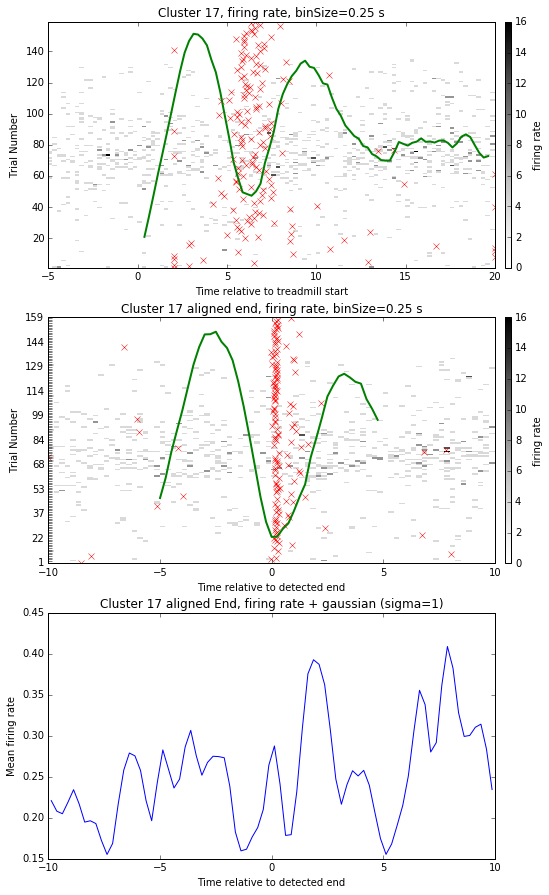

In [12]:
def compute_firing_rate_alignEnd(data,shank,cluster,binSize,minTime=-10,maxTime=10):
    timeBin=np.arange(minTime,maxTime+binSize-maxTime%binSize,binSize)
    firingRate={}
    spikeTime=data.spikeTime[shank][cluster]
    for trial in data.trials:
        end=data.timeEndTrial[trial]
        if isNone(end):
            continue
        zero=data.treadmillStartTime[trial]+end
        start=zero+minTime
        stop=zero+maxTime
        trialSpikeTime=spikeTime[(spikeTime>=start)&(spikeTime<=stop)]
        alignedTime=trialSpikeTime-zero
        hist,bins=np.histogram(alignedTime,timeBin)
        firingRate[trial]=hist/float(binSize)
    center=(timeBin[:-1]+timeBin[1:])/2
    return firingRate,center,timeBin

#----------------------------------------------------------------------------------------------------------------------
def plot_raster_firing_rate_alignEnd(data,shank,cluster,binSize=0.25,minTime=-10,maxTime=10,legend=False,ax=None):
    if ax is None:
        ax=plt.gca()
        
    firingRate,center,timeBin=compute_firing_rate_alignEnd(data,shank,cluster,binSize,minTime,maxTime)
    res=np.asarray(list(firingRate.values()))

    realTrials=[trial+1 for trial in data.trials if not isNone(data.timeEndTrial[trial])]
    
    y= [t+0.5 for t in range(1,len(realTrials)+2)]
    resColor=ax.pcolormesh(timeBin,y,res,cmap="Greys")

    box = ax.get_position()
    axColor = plt.axes([box.x0*1.02 + box.width * 1.02, box.y0, 0.01, box.height])
    plt.colorbar(resColor, cax=axColor, label="firing rate")

    yAxis=[y+0.5 for y in range(0,len(realTrials))]
    entrance=[data.entranceTime[trial-1]-data.timeEndTrial[trial-1] for trial in realTrials]
    ax.plot(entrance,yAxis,"x",color="red",label="Entrance times",linewidth=2)

    ax2=ax.twinx()
    ax2.axis("off")
    ax2.plot(data.timeAlignEnd,data.medianPositionAlignEnd,'g-',linewidth=2,label="Median position");
    
    #set correct ticks and limits
    ax.set_xlim([timeBin[0],timeBin[-1]])
    ax.set_yticks(yAxis)
    for i,label in enumerate(ax.get_yticklabels()):
        label.set_visible(not i%(len(yAxis)//10))
        
    ax.set_yticklabels([str(t) for t in realTrials])
    ax.set_ylim(0,len(realTrials))
    ax.set_xlabel("Time relative to detected end")
    ax.set_ylabel("Trial Number")
    ax.set_title("Cluster %s aligned end, firing rate, binSize=%s s"%(cluster,data.binSize))

#----------------------------------------------------------------------------------------------------------------------
def plot_mean_firing_rate_alignEnd(data,shank,cluster,binSize=0.25,minTime=-10,maxTime=10,sigma=1,ax=None):
    if ax is None:
        ax=plt.gca()
    
    firingRate,center,timeBin=compute_firing_rate_alignEnd(data,shank,cluster,binSize,minTime,maxTime)
    spikeCount=np.mean(list(firingRate.values()),axis=0)
    
    import scipy.ndimage as scImage
    smoothSpikeCount=scImage.filters.gaussian_filter1d(spikeCount, sigma) 
    
    ax.plot(center,smoothSpikeCount);
    ax.set_xlabel("Time relative to detected end")
    ax.set_ylabel("Mean firing rate")
    ax.set_title("Cluster %s aligned End, firing rate + gaussian (sigma=%s)"%(cluster,sigma))   

#----------------------------------------------------------------------------------------------------------------------
if "__file__" not in dir():
    SHANK=1
    CLU=17

    plt.figure(figsize=(8,15))
    plt.subplot(311)
    plot_raster_firing_rate(data,SHANK,CLU)

    plt.subplot(312)
    plot_raster_firing_rate_alignEnd(data,SHANK,CLU)

    plt.subplot(313)
    plot_mean_firing_rate_alignEnd(data,SHANK,CLU)

###  Autocorrelogram

[2 2 0 0 1 0 1 0 1 2 2 1 4 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1
 0 0 0 0 0 1 1 1 0 0 1 4 1 2 2 1 0 1 0 1 0 0 2 2]
[3 3 0 ..., 0 3 3]


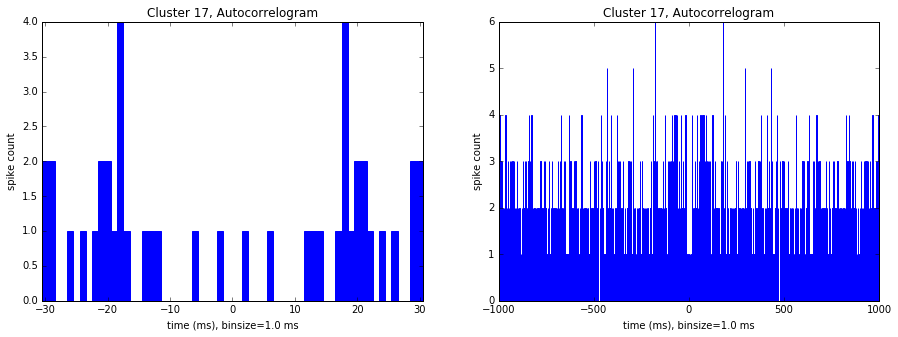

In [31]:
import KWIKphy.stats

def plot_autocorrelogram(data, shank, cluster, bin_ms=1,half_width_ms=25,ax=None):
    if ax is None:
        ax=plt.gca()
    
    bin_ms=np.clip(bin_ms,.1,1e3) #bin size in ms, rounded
    binsize=int(data.spikeSamplingRate*bin_ms*0.001) #bin size in time samples
    
    half_width_ms=np.clip(half_width_ms,.1,1e3) #ms, rounded
    winsize_bins= 2*int(half_width_ms/bin_ms) +1 #number of bins in window

    sample=data.spikeSample[shank][cluster]
    clu=np.ones_like(sample,dtype="int64")
    
    pairwiseCorr=KWIKphy.stats.pairwise_correlograms(sample,clu,binsize,winsize_bins)

    autoCorr=pairwiseCorr[0,0,:]
    
    halfWinsize=winsize_bins//2
    xaxis=np.arange(-halfWinsize-0.5, halfWinsize+1.5)
    xaxis=xaxis*binsize/data.spikeSamplingRate*1000 #ms
    
    ax.bar(xaxis[:-1],autoCorr,width=bin_ms,color="blue",edgecolor="blue");
    ax.set_title("Cluster %s, Autocorrelogram"%cluster);
    ax.set_xlim([xaxis[0],xaxis[-1]]);
    ax.set_xlabel("time (ms), binsize=%s ms"%bin_ms)
    ax.set_ylabel("spike count")

#----------------------------------------------------------------------------------------------------------------------
if "__file__" not in dir():
    shank=1
    clusterID = 17

    #bin_ms: bin size in ms
    bin_ms=1
    #half_width_ms: half width of the x axis (time), in ms
    half_width_ms=30 #1000

    plt.figure(figsize=(15,5))    
    plt.subplot(121)
    plot_autocorrelogram(data,shank,clusterID,bin_ms,30)
    plt.subplot(122)
    plot_autocorrelogram(data,shank,clusterID,bin_ms,1000)

### Autocorrelogram for trial/intertrial

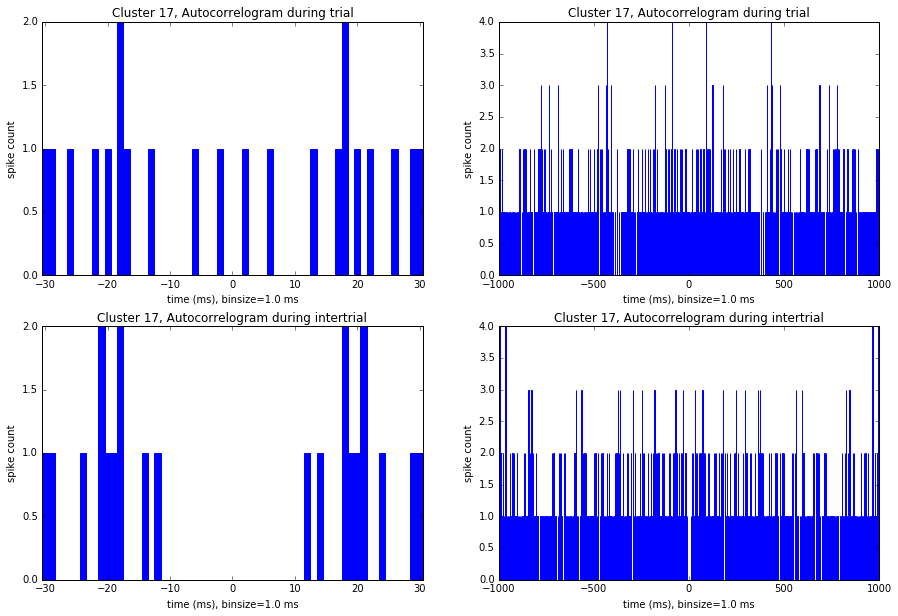

In [14]:
import KWIKphy.stats

def plot_autocorrelogram_trial(data,shank,cluster,bin_ms=1,half_width_ms=25,minTime=-5,maxTime=20,inTrial=True,ax=None):
    if ax is None:
        ax=plt.gca()
    
    bin_ms=np.clip(bin_ms,.1,1e3) #bin size in ms, rounded
    binsize=int(data.spikeSamplingRate*bin_ms*0.001) #bin size in time samples
    
    half_width_ms=np.clip(half_width_ms,.1,1e3) #ms, rounded
    winsize_bins= 2*int(half_width_ms/bin_ms) +1 #number of bins in window

    sample=data.spikeSample[shank][cluster]
    spikeTime=data.spikeTime[shank][cluster]
    
    isInTrial=np.full_like(sample,False)
    #select only spike during trials
    for trial in data.trials:
        start=data.treadmillStartTime[trial]
        stop=data.cameraStartTime[trial]+data.stopFrame[trial]/data.cameraSamplingRate
        isInTrial=np.logical_or(isInTrial,(spikeTime>start)&(spikeTime<stop))
    
    if inTrial:
        newSample=sample[isInTrial]
        title="trial"
    else:
        newSample=sample[np.invert(isInTrial)]
        title="intertrial"
    clu=np.ones_like(newSample,dtype="int64")

    pairwiseCorr=KWIKphy.stats.pairwise_correlograms(newSample,clu,binsize,winsize_bins)

    autoCorr=pairwiseCorr[0,0,:]
    
    halfWinsize=winsize_bins//2
    xaxis=np.arange(-halfWinsize-0.5, halfWinsize+1.5)
    xaxis=xaxis*binsize/data.spikeSamplingRate*1000 #ms
    
    ax.bar(xaxis[:-1],autoCorr,width=bin_ms,color="blue",edgecolor="blue");
    ax.set_title("Cluster %s, Autocorrelogram during %s"%(cluster,title));
    ax.set_xlim([xaxis[0],xaxis[-1]]);
    ax.set_xlabel("time (ms), binsize=%s ms"%bin_ms)
    ax.set_ylabel("spike count")

#----------------------------------------------------------------------------------------------------------------------
if "__file__" not in dir():
    plt.figure(figsize=(15,10))    
    plt.subplot(221)
    plot_autocorrelogram_trial(data,shank,clusterID,bin_ms,30)
    plt.subplot(222)
    plot_autocorrelogram_trial(data,shank,clusterID,bin_ms,1000)
    plt.subplot(223)
    plot_autocorrelogram_trial(data,shank,clusterID,bin_ms,30,inTrial=False)
    plt.subplot(224)
    plot_autocorrelogram_trial(data,shank,clusterID,bin_ms,1000,inTrial=False)

### Waveform for teresa's data (.kwx)
  - Load .kwx with h5py and .kwik with phy  
  - Choose randomly 150 spikes from a cluster
  - Do not plot spike if mask=0
  
  in kwik/kwx format, spikeIndex are the index in the kwx file
  
  spikeSample are the index in dat file (once it's reshaped as `nSample*nChannel`)

In [15]:
import h5py
from KWIKphy.session import Session

def read_dat_waveform(data, shank, cluster, subSample = 150, extract = 16):
    #memory map to dat file
    dtype = np.int16
    size = os.stat(data.fullPath + '.dat').st_size
    row_size = data.nChannels * np.dtype(dtype).itemsize
    if size % row_size != 0:
        raise ValueError(("Shape error: the file {f} has S={s} bytes, "
                          "but there are C={c} channels. C should be a divisor of S."
                          "").format(f=filename, s=size, c=self.nchannels))
    nsamples = size // row_size
    shape = (nsamples, data.nChannels)
    datFile = np.memmap(data.fullPath + '.dat', dtype = dtype, mode = 'r', offset = 0, shape = shape)
    #indexes of spikes for this cluster
    spikeID = data.spikeSample[shank][cluster]
    nSpike = len(spikeID)
    if nSpike > subSample:
        spikeID = np.random.choice(spikeID, subSample, replace = False)
        nSpike = subSample
    #get waveform for each index
    waveform = np.zeros(shape=(nSpike, extract * 2, len(data.channelGroupList[shank])), dtype=dtype )
    for index, spike in enumerate(spikeID):
        waveform[index, :, :] = datFile[spike-extract : spike+extract, data.channelGroupList[shank]]
    return waveform

def read_kwx_waveform(data, shank, clusterID, sample = 150):
    """
    kwx array = [ spikes indexes, n data points, n channels]
    """
    if not os.path.exists(data.fullPath+".kwx"):
        return
    with h5py.File(data.fullPath+".kwx","r") as kwx:  
        waveform = kwx.get('channel_groups/%s/waveforms_raw' % shank)[()]
    print(waveform.shape)
    #index of spikes where cluster==X
    spikeID=data.spikeIndex[shank][clusterID]
    print(max(spikeID))
    if len(spikeID) > sample:
        spikeID = np.random.choice(spikeID, sample, replace = False)
    return waveform[spikeID, :, :]

In [28]:
if "__file__" not in dir():
    animal="Rat034"
    experiment="Rat034_2015_02_20_13_34" 
    data=Data(root,animal,experiment,param,redoPreprocess=True)
    for shank in data.channelGroupList:
            print("shank %s:"%shank)
            print(data.clusterGroup[shank])

Preprocessing behavior data...
Behavior data loaded from text files: Teresa data (.samplingrate)
Preprocessing done
12:03:40 [W] Unable to read '/home/david/.phy/internal_settings'. Please try to delete this file.
12:03:40 [W] Could not find any data source for traces (raw.kwd or .dat or .bin.) Waveforms and traces will not be available.
12:03:40 [W] Unable to read '/home/david/.phy/internal_settings'. Please try to delete this file.
Features and masks initialized.
Initializing statistics: 100.0%.
Statistics initialized.
Initializing statistics: 100.0%.
12:03:41 [I] Switched to channel group 2.
12:03:41 [W] Unable to read '/home/david/.phy/internal_settings'. Please try to delete this file.
Features and masks initialized.
Initializing statistics: 100.0%.
Statistics initialized.
Initializing statistics: 100.0%.
12:03:41 [I] Switched to channel group 3.
12:03:41 [W] Unable to read '/home/david/.phy/internal_settings'. Please try to delete this file.
Features and masks initialized.
Initia

(479274, 32, 8)
462325


/home/david/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


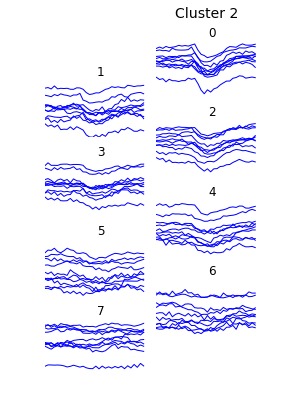

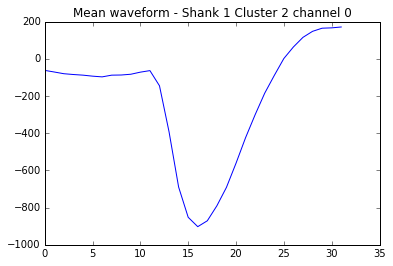

In [16]:
#Mean waveform from .kwx
def plot_mean_waveform(data, shank, clusterID, noPlot = False, sample = 150, kwx = True):
    
    if kwx:
        waveform = read_kwx_waveform(data, shank, clusterID, sample)
    else:
        waveform = read_dat_waveform(data, shank, clusterID, sample)
    
    minMax = 0
    meanWaveform = []
    ch = 0
    for channel in range(waveform.shape[2]):
        meanChannel = np.mean(waveform[:, :, channel], axis = 0)
        minMaxChannel = np.max(meanChannel) - np.min(meanChannel)
        if minMaxChannel > minMax:
            minMax = minMaxChannel
            meanWaveform = meanChannel
            ch = channel
    if not noPlot:
        plt.plot(meanWaveform)
        plt.title("Mean waveform - Shank %s Cluster %s channel %s" %(shank, clusterID, ch))
    return meanWaveform
        
#Loading waveform from .kwx
def plot_waveforms(data, shank, clusterID, group="not specified", sample = 150, kwx = True):
    
    if kwx:
        waveform = read_kwx_waveform(data, shank, clusterID, sample)
    else:
        waveform = read_dat_waveform(data, shank, clusterID, sample)
    
    place = [[0, 1], [1, 0], [2, 1], [3, 0], [4, 1], [5, 0], [6, 1], [7, 0]]           
    plt.figure(figsize = (3*2, 6))
    plt.suptitle("Cluster %s" % clusterID, fontsize = 14)
    gs = gridspec.GridSpec(8, 3, hspace = -0.3, wspace = 0)    
    for channel in range(waveform.shape[2]):
        channelWaveform = waveform[:, :, channel] 
        x = place[channel][0]
        y = place[channel][1]
        ax = plt.subplot(gs[x,y])
        for spike in channelWaveform:
            ax.plot(spike, color = "blue");
        ax.set_title("%s" % channel)
        ax.set_axis_off() 
    return

#old name of the function
plot_waveforms_teresa = plot_waveforms

#----------------------------------------------------------------------------------------------------------------------
if "__file__" not in dir():
    shank = 1
    clu = 2
    plot_waveforms(data, shank, clu, sample=10,kwx=False)
    plt.figure()
    plot_mean_waveform(data, shank, clu)

### General plot on each cluster

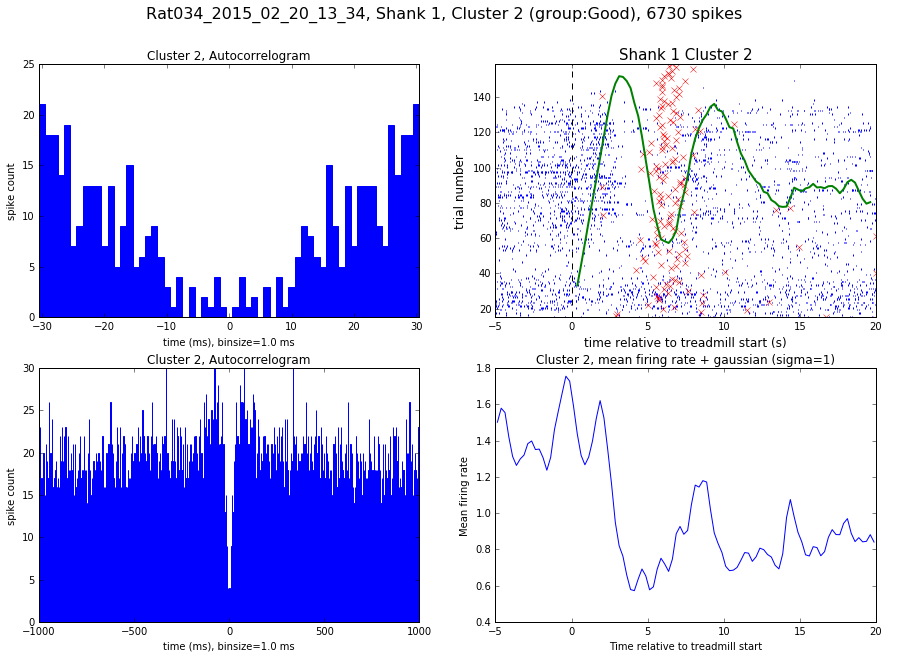

In [17]:
def plot_raster_correlogram(data,shank,cluster,group="not specify"):
    
    cluSpikeTime=data.spikeTime[shank][cluster]
    
    plt.figure(figsize=(15,10))
    plt.subplot(222)

    if len(cluSpikeTime)>20000:
        plot_raster_firing_rate(data,shank,cluster)
    else:
        plot_raster(data,shank,cluster)
        
    plt.subplot(224)
    plot_mean_firing_rate(data,shank,cluster)
    plt.subplot(221)
    plot_autocorrelogram(data,shank,cluster,1,30)
    plt.subplot(223)
    plot_autocorrelogram(data,shank,cluster,1,1000)
    
    exp=data.experiment
    plt.suptitle("%s, Shank %s, Cluster %s (group:%s), %s spikes"%(exp,shank,cluster,group,len(cluSpikeTime)),fontsize=16)

#----------------------------------------------------------------------------------------------------------------------
if "__file__" not in dir():
    shank=1
    cluster=2
    plot_raster_correlogram(data,shank,cluster,"Good")